### Cloud Mask Project

Abstract of the project available in https://docs.google.com/document/d/1T-uMGFXgOIb0-DgFu4H25VU6gPrn4d5ybH_vMQYK2aI/edit

To do:
- (Done) Find the way to login to Earthdata just once for all the VIIRS + ATL06 retrievals
- Add all the features from ALT06 we find interesting and re-order columns
- Add time efficiently to ATL06 data frames (problem with timestamps)
- (Done) check if the time window is correct (how to access date and time in ATL?)
- Raise a better error messege for the case of missing data
- (Done) Index in the ATL06 dataframes. There are a lot of repetitions
- (Done) Grid correction: do the vertices on VIIDS correspond to the center of the cell or to the real vertices of a cell? In that case, we need to shift the net.
(Answer: this is for MODIS)
- Change Ball Tree for something faster
- Which is a good spatial window for VIIRS? 1km? How to go from (delta_lat, delta_lon) to delta_meters?
- Should I be careful with the VIIRS images we use? Focus maybe on some moment of the year + some region (Antarctice y/o Greenland)
- Is there any way to access VIIRS metadata?
- Parallelize each VIIRS call
- Where to call each library and python script?

In [1]:
from icepyx import query as ipd
#from icepyx import icesat2data as ipd

from pathlib import Path
import h5py
import os
import numpy as np
import pandas as pd
import pyproj
import pickle
from astropy.time import Time
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import get_file_in_directory, is_file_in_directory, gps2dyr
from utils_atl06 import read_atl06_fromfile, atl06_2_df, read_atl06
from utils_viirs import associate, viirs_date

### VIIRS Asimilation

In [4]:
# Directory where the VIIRS data is located
path_data_VIIRS = 'data/VIIRS/'
# Directory where the ATL06 is located or should be downloaded 
path_data_ATL06 = 'data/new_ATL06/'

# Window in hours to retrieve ICESat-2 data around VIIRS image
hr = 0.5
# Name of the column with the difference in minutes between ICESat-2 and VIIRS
cld_t_var = 'VIIRS_offset'
# Name of the variable with the cloud mask indicatos in VIIRS
V_variable = 'Integer_Cloud_Mask'
# Number of nearest neighbours to consider for the assimilation
k = 3
# Distance in kilometers above which ICESat-2 measuraments will be discarted in case that there is no spatial match with VIIRS
tolerance_spatial_dismatch = 1 
# Approximate radii of the Earth
radii = 6371

In [26]:
Vfiles = get_file_in_directory(path_data_VIIRS)

VIIRS_2_ATL06 = {}

for Vfile in Vfiles: 

    """
    Atmospheric product retrieval.
    
    This part should be return the same for all the external producs:
    
        - f_t: timestamp where the product was recorded
        - latS : 2-dimensional np.array with the latitudes
        - lonS : 2-dimensional np.array with the longitudes
        - extract : np.array with the label of the product
    
    """
    
    print("Name of VIIRS file:", Vfile)
    
    try:
    
        # Temportal properties
        f_ = h5py.File(Vfile)     
        f_t = viirs_date(Vfile)

        # Spatial properties
        latS = f_["geolocation_data"]["latitude"][:]
        lonS = f_["geolocation_data"]["longitude"][:]
        assert latS.shape == lonS.shape, "latS and lonS must have the same shape"

        # Label
        extract = f_['geophysical_data'][V_variable].value
        assert extract.shape == latS.shape, "Labels and latS must have the same shape"


        """
        Preprocesing of the atmospheric product 
        """

        # I change the coordinates to radians and I stack pairs of (latitude, longitede) 

        S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
        S_rad *= np.pi / 180.


        """
        ATL06 Retrieval
        """

        # Temporal search window for 
        start = f_t - pd.DateOffset(hours=hr)
        end   = f_t + pd.DateOffset(hours=hr)

        start_date_str = start.strftime('%Y-%m-%d')
        end_date_str   = end.strftime('%Y-%m-%d')
        start_time_str = start.strftime('%H:%M:%S')
        end_time_str   = end.strftime('%H:%M:%S')

        # I should be able to do this defining a rectangle that coincides with VIIRS, instead of a rectangle
        # defined by the parallels and meridians 
        lat_min = np.min(latS)
        lat_max = np.max(latS)
        lon_min = np.min(lonS)
        lon_max = np.max(lonS)

        #spatial_extent = [lon_min, lat_min, lon_max, lat_max]
        spatial_extent = [-50, 68, -45, 73]
        spatial_extent = [float(x) for x in spatial_extent]   # remove this line once Issue 82 is solved 

        date_range = [start_date_str, end_date_str]

        #df = df_preprocessed    
        df = read_atl06(spatial_extent = spatial_extent,
                        date_range = date_range,
                        time_start = start_time_str,
                        time_end = end_time_str,
                        path = path_data_ATL06)

        # I should add an extra filter here to be sure that all measuraments are in the desired temporal window
        # ...
        
        if df.shape[0] == 0:
            print("The retrieved dataframes has no entries.")
            continue

        latF = df.lat.values 
        lonF = df.lon.values

        F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
        F_rad *= np.pi / 180.

        """
        Assimilation
        """

        # Label Assimilation

        distances, indices = associate(S_rad, F_rad, k_nn=k)

        for i in range(indices.shape[1]):

            new_column = extract.ravel()[indices[:, i]]
            df[ V_variable + "_k" + str(i + 1) ] = new_column
            df[ V_variable + "_k" + str(i + 1) + "_dist" ] = distances[:, i]


        # I filter ATL points outside the VIIRS Image
        df = df[ df[V_variable + "_k1_dist"] < tolerance_spatial_dismatch / radii ]

        # Difference on time assimilation 
        df["delta_assim"] = abs( df.t_year - f_t ) / np.timedelta64(1,'m') 
        # I filter points outside the temporal window 
        df = df[ df["delta_assim"] < 60 * hr ]


        VIIRS_2_ATL06[Vfile] = df

        a_file = open("dict_VIIRS_2_ATL06_dt15.pkl", "wb")
        pickle.dump(VIIRS_2_ATL06, a_file)
        a_file.close()


    
    except:
        print("Error")
        
    
print("Process completed")

Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019293.1324.001.2019294005703.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20191020130940_03610505_003_01.h5']
You already donwload all the requiered files
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020076.1706.001.2020077010518.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20200316171638_12370603_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772552
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000772552 of  1  order(s) is downloaded.
Download complete
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020084.0618.001.2020084191353.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20200324061026_13520605_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772553
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  failed
NSIDC provided these error messages:
['180664469:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT3.657S',
 'ICESAT2']
Request failed.
Error
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020109.0512.001.2020109130041.nc
Available Granules: ['ATL06_20200418045451_03460705_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772554
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may t

<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20190823031237_08560403_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772556
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000772556 of  1  order(s) is downloaded.
Download complete
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020023.0842.001.2020023191909.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20200123084105_04220605_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772557
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000772557 of  1  order(s) is downloaded.
Download complete
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020060.0712.001.2020060190240.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20200229070026_09860605_003_01.h5']
You already donwload all the requiered files
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019268.1430.001.2019269011145.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20190925142517_13670405_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772563
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000772563 of  1  order(s) is downloaded.
Download complete
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019329.1206.001.2019330005829.nc


<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20191125115442_09100505_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772564
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  failed
NSIDC provided these error messages:
['178943062:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT2.973S',
 'ICESAT2']
Request failed.
Error
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019267.1448.001.2019268010420.nc
Available Granules: ['ATL06_20190924145056_13520405_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772565
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may t

<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value
<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)


Available Granules: ['ATL06_20191113121942_07270505_003_01.h5']
You already donwload all the requiered files
Name of VIIRS file: data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2020100.1618.001.2020101010636.nc


<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value
<ipython-input-26-9e5c1042807d>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)


Available Granules: ['ATL06_20200409162635_02160703_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000772608
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000772608 of  1  order(s) is downloaded.
Download complete
Process completed


<ipython-input-26-9e5c1042807d>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


In [21]:
a_file = open("dict_VIIRS_2_ATL06_dt15.pkl", "rb")

In [22]:
output = pickle.load(a_file)

In [43]:
VIIRS_2_ATL06.keys()

dict_keys(['data/VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019158.1354.001.2019159011937.nc'])

In [44]:
df = VIIRS_2_ATL06[list(VIIRS_2_ATL06.keys())[0]]

In [45]:
df

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,e_bckgrd,n_fit_photons,w_surface_window_final,Integer_Cloud_Mask_k1,Integer_Cloud_Mask_k1_dist,Integer_Cloud_Mask_k2,Integer_Cloud_Mask_k2_dist,Integer_Cloud_Mask_k3,Integer_Cloud_Mask_k3_dist,delta_assim


In [17]:
np.sum(df.Integer_Cloud_Mask_k1 == df.Integer_Cloud_Mask_k2) / df.shape[0]

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


nan

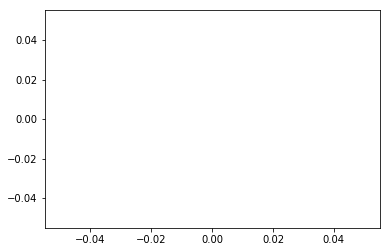

In [18]:
plt.scatter( df.lat[::10], df.lon[::10], c = df.Integer_Cloud_Mask_k1_dist[::10] , s = 3 )

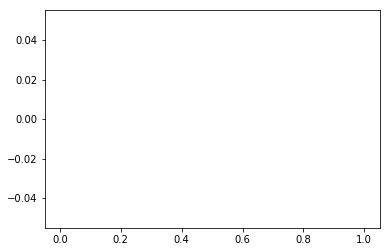

In [47]:
plt.hist(df.Integer_Cloud_Mask_k1_dist[::10] * 6400, 100);

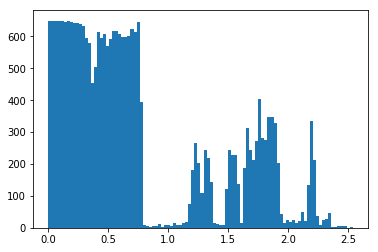

In [84]:
plt.hist(df.delta_assim[::10], 100);

In [5]:
import pickle

In [9]:
dictionary_data = {0: 10, 1: 2}

a_file = open("data.pkl", "wb")
pickle.dump(dictionary_data, a_file)
a_file.close()

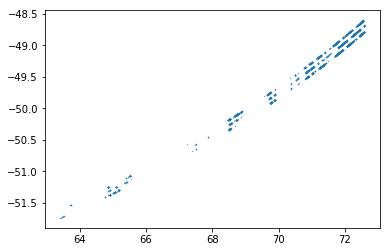

In [110]:
plt.scatter(df.lat[::10], df.lon[::10], s = 0.1)

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


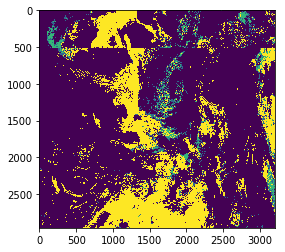

In [85]:
cloud_var = 'Integer_Cloud_Mask'

img = h5py.File(Vfiles[0])
Vdata = img['geophysical_data'][cloud_var].value
#plt.imshow(Vdata[1700:2200,2500:])
plt.imshow(Vdata)

### Opening dictonary

In [4]:
infile = open('dict_VIIRS_2_ATL06_dt15.pkl','rb')
dict_VIIRS2ATL = pickle.load(infile)
infile.close()

In [13]:
list_keys = ist(dict_VIIRS2ATL.keys()

for x in list_keys:
                
    
                

SyntaxError: invalid syntax (<ipython-input-13-6cb6ea055655>, line 3)

In [39]:
list_keys = list(dict_VIIRS2ATL.keys())
res = 0
for x in list_keys:
    
    #print(x)
    print(dict_VIIRS2ATL[x].shape)
    res += dict_VIIRS2ATL[x].shape[0]

(48007, 30)
(0, 30)
(12275, 30)
(10654, 30)
(117651, 30)
(450498, 30)
(89692, 30)
(1507, 30)
(122412, 30)
(94294, 30)
(102557, 30)
(136029, 30)
(76305, 30)
(135984, 30)
(107185, 30)
(1163, 30)
(0, 30)
(67887, 30)
(105411, 30)
(2490, 30)
(61178, 30)
(1512, 30)
(129939, 30)
(62386, 30)
(0, 30)
(111130, 30)
(21187, 30)
(60253, 30)
(15014, 30)
(68571, 30)
(83782, 30)
(418, 30)
(122130, 30)
(61734, 30)
(17250, 30)
(168595, 30)
(65114, 30)
(98583, 30)
(25578, 30)
(167642, 30)
(66517, 30)
(183834, 30)
(25813, 30)
(44437, 30)
(0, 30)
(33243, 30)
(145205, 30)
(143907, 30)


In [27]:
pd.concat([dict_VIIRS2ATL[list_keys[3]], dict_VIIRS2ATL[list_keys[4]]], ignore_index=True)

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,e_bckgrd,n_fit_photons,w_surface_window_final,Integer_Cloud_Mask_k1,Integer_Cloud_Mask_k1_dist,Integer_Cloud_Mask_k2,Integer_Cloud_Mask_k2_dist,Integer_Cloud_Mask_k3,Integer_Cloud_Mask_k3_dist,delta_assim
0,gt1l,2019-08-23 03:16:44.367541,405186,72.773215,-45.956871,2766.586670,0.011937,0,0,0.0,...,0.0,442,3.0,3,0.000156,3,0.000191,3,0.000261,4.739459
1,gt1l,2019-08-23 03:16:44.370362,405187,72.773393,-45.956952,2766.602783,0.012320,0,0,0.0,...,0.0,446,3.0,3,0.000154,3,0.000191,3,0.000262,4.739506
2,gt1l,2019-08-23 03:16:44.373186,405188,72.773571,-45.957034,2766.590332,0.013746,0,0,0.0,...,0.0,448,3.0,3,0.000153,3,0.000190,3,0.000264,4.739553
3,gt1l,2019-08-23 03:16:44.376015,405189,72.773748,-45.957117,2766.585693,0.013366,0,0,0.0,...,0.0,447,3.0,3,0.000151,3,0.000190,3,0.000266,4.739600
4,gt1l,2019-08-23 03:16:44.378850,405190,72.773926,-45.957202,2766.592529,0.012025,0,0,0.0,...,0.0,455,3.0,3,0.000149,3,0.000190,3,0.000267,4.739648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128300,gt3r,2020-01-23 08:44:53.216251,623490,68.000890,-46.340806,1956.573730,0.014424,0,0,0.0,...,0.0,328,3.0,3,0.000092,3,0.000121,3,0.000130,2.886938
128301,gt3r,2020-01-23 08:44:53.219060,623491,68.000712,-46.340862,1956.596924,0.014345,0,0,0.0,...,0.0,318,3.0,3,0.000092,3,0.000124,3,0.000130,2.886984
128302,gt3r,2020-01-23 08:44:53.221869,623492,68.000533,-46.340917,1956.598877,0.012576,0,0,0.0,...,0.0,326,3.0,3,0.000092,3,0.000126,3,0.000130,2.887031
128303,gt3r,2020-01-23 08:44:53.224679,623493,68.000355,-46.340972,1956.626343,0.013953,0,0,0.0,...,0.0,305,3.0,3,0.000092,3,0.000128,3,0.000130,2.887078


In [40]:
res

3666953

In [23]:
dict_VIIRS2ATL[list_keys[3]]

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,e_bckgrd,n_fit_photons,w_surface_window_final,Integer_Cloud_Mask_k1,Integer_Cloud_Mask_k1_dist,Integer_Cloud_Mask_k2,Integer_Cloud_Mask_k2_dist,Integer_Cloud_Mask_k3,Integer_Cloud_Mask_k3_dist,delta_assim
10554,gt1l,2019-08-23 03:16:44.367541,405186,72.773215,-45.956871,2766.586670,0.011937,0,0,0.0,...,0.0,442,3.0,3,0.000156,3,0.000191,3,0.000261,4.739459
10555,gt1l,2019-08-23 03:16:44.370362,405187,72.773393,-45.956952,2766.602783,0.012320,0,0,0.0,...,0.0,446,3.0,3,0.000154,3,0.000191,3,0.000262,4.739506
10556,gt1l,2019-08-23 03:16:44.373186,405188,72.773571,-45.957034,2766.590332,0.013746,0,0,0.0,...,0.0,448,3.0,3,0.000153,3,0.000190,3,0.000264,4.739553
10557,gt1l,2019-08-23 03:16:44.376015,405189,72.773748,-45.957117,2766.585693,0.013366,0,0,0.0,...,0.0,447,3.0,3,0.000151,3,0.000190,3,0.000266,4.739600
10558,gt1l,2019-08-23 03:16:44.378850,405190,72.773926,-45.957202,2766.592529,0.012025,0,0,0.0,...,0.0,455,3.0,3,0.000149,3,0.000190,3,0.000267,4.739648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61446,gt3r,2019-08-23 03:16:48.136136,406413,72.999198,-45.862370,2773.805420,0.020971,0,0,0.0,...,0.0,99,3.0,3,0.000065,3,0.000139,3,0.000167,4.802269
61447,gt3r,2019-08-23 03:16:48.138947,406414,72.999375,-45.862453,2773.790771,0.016291,0,0,0.0,...,0.0,106,3.0,3,0.000062,3,0.000137,3,0.000170,4.802316
61448,gt3r,2019-08-23 03:16:48.141758,406415,72.999553,-45.862537,2773.770020,0.018823,0,0,0.0,...,0.0,111,3.0,3,0.000060,3,0.000135,3,0.000173,4.802363
61449,gt3r,2019-08-23 03:16:48.144572,406416,72.999730,-45.862620,2773.727539,0.018866,0,0,0.0,...,0.0,119,3.0,3,0.000058,3,0.000133,3,0.000175,4.802410


In [24]:
dict_VIIRS2ATL[list_keys[4]]

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,e_bckgrd,n_fit_photons,w_surface_window_final,Integer_Cloud_Mask_k1,Integer_Cloud_Mask_k1_dist,Integer_Cloud_Mask_k2,Integer_Cloud_Mask_k2_dist,Integer_Cloud_Mask_k3,Integer_Cloud_Mask_k3_dist,delta_assim
0,gt1l,2020-01-23 08:44:00.857052,605024,71.281470,-45.000048,2627.248047,0.025291,0,0,0.0,...,0.0,68,3.0,3,0.000047,3,0.000087,3,0.000095,2.014284
1,gt1l,2020-01-23 08:44:00.859879,605025,71.281293,-45.000123,2627.223877,0.018931,0,0,0.0,...,0.0,69,3.0,3,0.000048,3,0.000085,3,0.000094,2.014331
2,gt1l,2020-01-23 08:44:00.862703,605026,71.281115,-45.000197,2627.132812,0.025835,0,0,0.0,...,0.0,88,3.0,3,0.000050,3,0.000084,3,0.000093,2.014378
3,gt1l,2020-01-23 08:44:00.865527,605027,71.280937,-45.000270,2627.079590,0.024483,0,0,0.0,...,0.0,93,3.0,3,0.000051,3,0.000083,3,0.000092,2.014425
4,gt1l,2020-01-23 08:44:00.868350,605028,71.280759,-45.000343,2627.049561,0.026672,0,0,0.0,...,0.0,77,3.0,3,0.000053,3,0.000081,3,0.000091,2.014473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118177,gt3r,2020-01-23 08:44:53.216251,623490,68.000890,-46.340806,1956.573730,0.014424,0,0,0.0,...,0.0,328,3.0,3,0.000092,3,0.000121,3,0.000130,2.886938
118178,gt3r,2020-01-23 08:44:53.219060,623491,68.000712,-46.340862,1956.596924,0.014345,0,0,0.0,...,0.0,318,3.0,3,0.000092,3,0.000124,3,0.000130,2.886984
118179,gt3r,2020-01-23 08:44:53.221869,623492,68.000533,-46.340917,1956.598877,0.012576,0,0,0.0,...,0.0,326,3.0,3,0.000092,3,0.000126,3,0.000130,2.887031
118180,gt3r,2020-01-23 08:44:53.224679,623493,68.000355,-46.340972,1956.626343,0.013953,0,0,0.0,...,0.0,305,3.0,3,0.000092,3,0.000128,3,0.000130,2.887078


In [5]:
from sklearn.utils import shuffle

def merge_df_from_dict(dictonary, entries_to_merge = "all", shuffle = False):
    """
    Takes a dictonary with keys associated to a pandas dataframe with the same column and marges all the dataframes into a single one
    """
    
    if entries_to_merge == "all":
        entries = list(dictonary.keys())
    else:
        entries = entries_to_merge
        
    dfs = []
    for x in entries:
        dfs.append(dictonary[x])
        
    df = pd.concat(dfs, ignore_index=True)
    
    if shuffle:
        df = shuffle(df).reset_index(drop=True)
        
    return df

In [6]:
df = merge_df_from_dict(dict_VIIRS2ATL)

In [7]:
df.columns

Index(['ground_track', 't_year', 'segment_id', 'lat', 'lon', 'h_li', 's_li',
       'q_flag', 's_fg', 'snr', 'h_rb', 'dh_fit_dx', 'b_snow_conf',
       'c_flg_asr', 'c_flg_atm', 'msw', 'bsnow_h', 'bsnow_od', 'layer_flag',
       'bckgrd', 'e_bckgrd', 'n_fit_photons', 'w_surface_window_final',
       'Integer_Cloud_Mask_k1', 'Integer_Cloud_Mask_k1_dist',
       'Integer_Cloud_Mask_k2', 'Integer_Cloud_Mask_k2_dist',
       'Integer_Cloud_Mask_k3', 'Integer_Cloud_Mask_k3_dist', 'delta_assim'],
      dtype='object')

In [10]:
df.sample(frac = 0.0001).plot.hist(by = "t_year")

ValueError: view limit minimum -1.7014117331926443e+37 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -1.7014117331926443e+37 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [21]:
plt.close()
df.sample(frac = 0.0001).plot.hist(by = "lat")

ValueError: view limit minimum -1.7014117331926443e+37 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -1.7014117331926443e+37 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

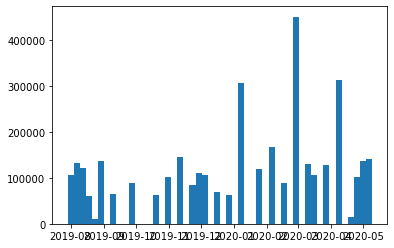

In [36]:
plt.hist(df.t_year.values, 50);

### EDA perfect match

In [51]:
df = pd.read_csv("df_atl06_perfectmatch.csv")

In [56]:
def hist_df(df, var, by, bins = 50):
    
    classes = np.unique(df[by])
    
    for c in classes:
        _ = plt.hist( list(df[ df[by] == c ][var] ), bins, alpha = 0.5, label = c )

    plt.title("Histogram of " + str(var) + " grouped by " + str(by))
    plt.legend()
    plt.show
    return None

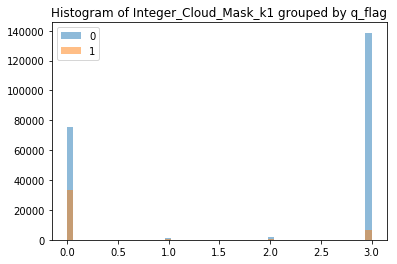

In [63]:
hist_df(df, var = "Integer_Cloud_Mask_k1", by = "q_flag")

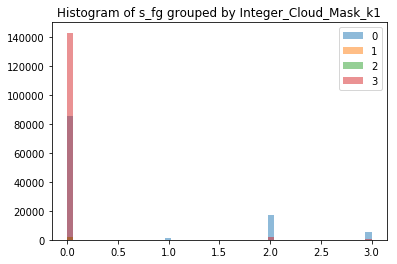

In [62]:
hist_df(df, var = "s_fg", by = "Integer_Cloud_Mask_k1")

In [65]:
pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1)

Integer_Cloud_Mask_k1,0,1,2,3
q_flag,,,,
0,75420,1488,1737,138702
1,33528,459,566,6410


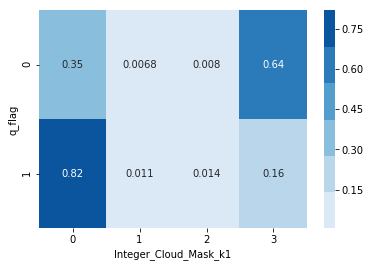

In [77]:
import seaborn as sns

ax = sns.heatmap(pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

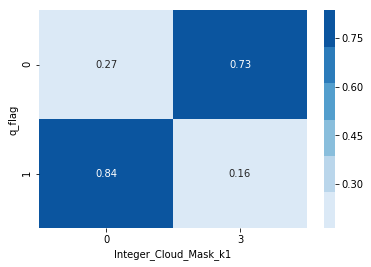

In [95]:
df2 = df[ df.delta_assim < 0.4 ]

ax = sns.heatmap(pd.crosstab(df2.q_flag,df2.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

### Functions I didn't use

In [37]:
# Do we use this function?
def orbit_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


def print_attrs(name, obj):
    '''
    Retrieves all attributes from hd5 file
    Use: f.visititems(print_attrs)
    '''
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

In [38]:
print_attrs(f_)

TypeError: print_attrs() missing 1 required positional argument: 'obj'